In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import os
import glob
import json

In [ ]:
# ==========================================
# 1. USER CONFIGURATION
# ==========================================
INPUT_PATH = "C:\\Users\\User\\Downloads\\All Study Shits\\Each Sem Material\\Y4S1\\BERR4723 Digital Image Processing\\Assignment\\LandscapeImages\\LandscapeDesert.jpg"  # Option A: Single File
# INPUT_PATH = "C:\\Users\\User\\Downloads\\All Study Shits\\Each Sem Material\\Y4S1\\BERR4723 Digital Image Processing\\Assignment\\LandscapeImages"      # Option B: Folder

OUTPUT_FOLDER = "processed_results"
PRESET_FILE = "enhancement_presets.json"

# Select which Scene Enhancement Preset to use
# Available: DayLandscape_Natural, DayLandscape_UrbanBuildings, GoldenHour_Sunset, 
#            OvercastCloudy, BeachCoastal, ForestGreenLandscape, MountainAlpine,
#            UrbanReflectiveGlass, BacklitLandscape, DesertArid
SELECTED_PRESET = "DesertArid"  # Change this to test different presets

# ==========================================
# DEGRADATION SETTINGS (To Simulate "Bad" Images)
# ==========================================
APPLY_DEGRADATION = True  # Set to True to degrade high-quality images before enhancement

DEGRADATION_CONFIG = {
    "contrast_reduction": 0.6,    # 0.0-1.0: How much to flatten contrast (0.5 = moderate)
    "underexposure": 0.8,         # 0.0-1.0: Darken factor (0.8 = moderate darkening)
    "noise_amount": 15,           # 0-50: Gaussian noise level (15 = light noise)
    "saturation_reduction": 0.8   # 0.0-1.0: Reduce color saturation (0.8 = slight reduction)
}

# ==========================================
# 2. LOAD PRESET CONFIGURATION
# ==========================================
def load_preset(preset_name):
    """Load enhancement preset from JSON file"""
    with open(PRESET_FILE, 'r') as f:
        presets = json.load(f)
    
    if preset_name not in presets["SceneEnhancementPresets"]:
        available = ", ".join(presets["SceneEnhancementPresets"].keys())
        raise ValueError(f"Preset '{preset_name}' not found. Available: {available}")
    
    preset = presets["SceneEnhancementPresets"][preset_name]
    print(f"✓ Loaded preset: {preset_name}")
    print(f"  - CLAHE clip_limit: {preset.get('clahe', {}).get('clip_limit', 'N/A')}")
    print(f"  - Blend strength: {preset.get('blend_strength', 'N/A')}")
    print(f"  - Sky protection power: {preset.get('sky_protection', {}).get('power', 'N/A')}")
    print(f"✓ Degradation: {'ENABLED' if APPLY_DEGRADATION else 'DISABLED'}")
    return preset

# Load the selected preset
PRESET_CONFIG = load_preset(SELECTED_PRESET)

✓ Loaded preset: DesertArid
  - CLAHE clip_limit: 2.0
  - Blend strength: 0.5
  - Sky protection power: 4


--- Processing: LandscapeDesert.jpg ---
PSNR: 31.04 dB | SSIM: 0.9873
Preset: DesertArid


C:\Users\User\AppData\Local\Temp\ipykernel_23148\2707459606.py:97: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.hist(l_orig.flatten(), 256, [0, 256], color='gray', alpha=0.5, label='Original')
C:\Users\User\AppData\Local\Temp\ipykernel_23148\2707459606.py:98: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.hist(l_final.flatten(), 256, [0, 256], color='green', alpha=0.5, label='Enhanced')


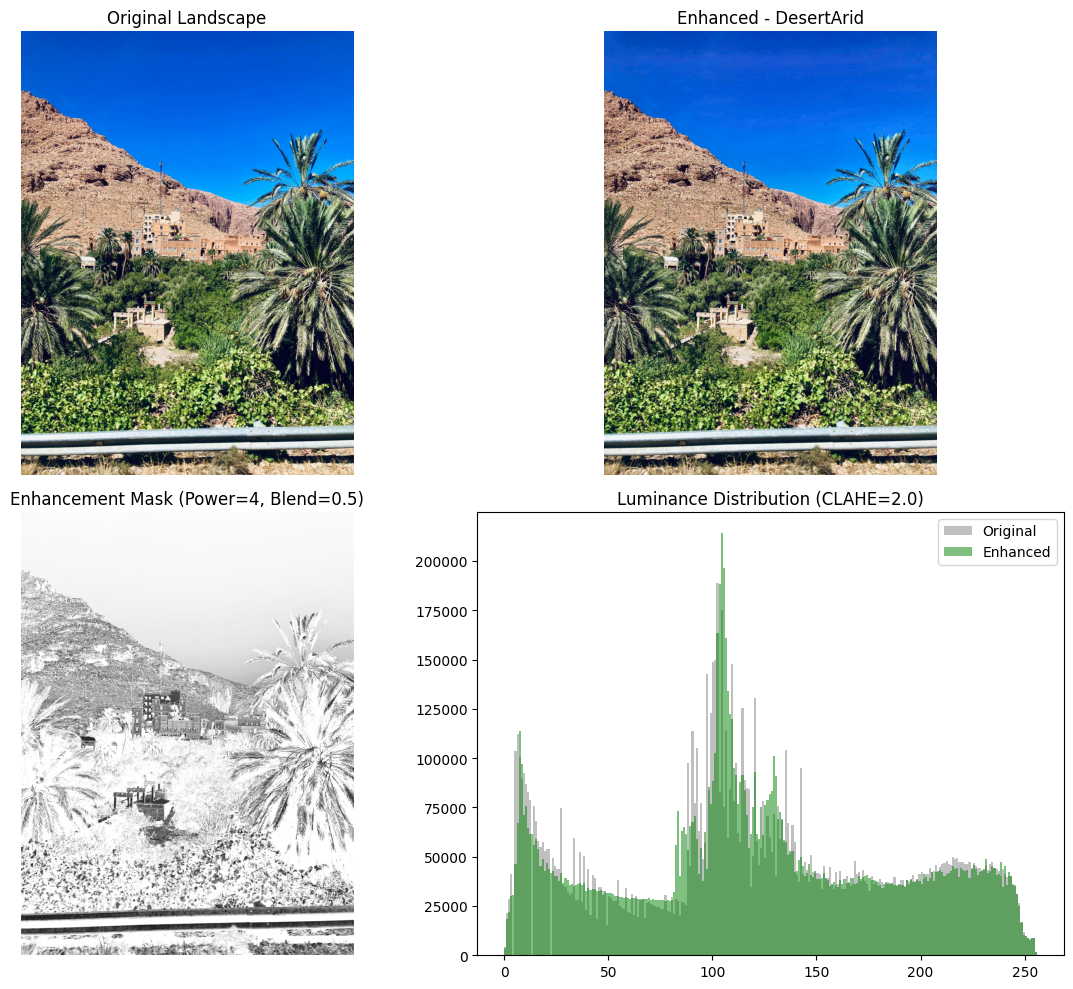

In [ ]:
# ==========================================
# 3. IMAGE DEGRADATION FUNCTION
# ==========================================

def degrade_image(img, config):
    """
    Degrade a high-quality image to simulate poor capture conditions.
    This makes enhancement results more visible and impressive.
    """
    img_float = img.astype(np.float32) / 255.0
    
    # 1. Reduce Contrast (Flatten Histogram)
    # Move all pixels toward middle gray (0.5)
    contrast_factor = config.get("contrast_reduction", 0.6)
    img_float = img_float * contrast_factor + 0.5 * (1 - contrast_factor)
    
    # 2. Simulate Underexposure (Darken)
    underexp_factor = config.get("underexposure", 0.8)
    img_float = np.power(img_float, 1.0 / underexp_factor)
    
    # 3. Reduce Saturation (Make Colors Dull)
    sat_factor = config.get("saturation_reduction", 0.8)
    hsv = cv2.cvtColor((img_float * 255).astype(np.uint8), cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 1] = hsv[:, :, 1] * sat_factor  # Reduce saturation channel
    img_degraded = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR).astype(np.float32) / 255.0
    
    # 4. Add Realistic Noise (Low-Light Sensor Noise)
    noise_level = config.get("noise_amount", 15)
    if noise_level > 0:
        noise = np.random.normal(0, noise_level / 255.0, img_degraded.shape).astype(np.float32)
        img_degraded = img_degraded + noise
    
    # Clip to valid range
    img_degraded = np.clip(img_degraded * 255, 0, 255).astype(np.uint8)
    
    return img_degraded

# ==========================================
# 4. CORE ENHANCEMENT LOGIC
# ==========================================

def calculate_psnr(img1, img2):
    return cv2.PSNR(img1, img2)

def process_one_image(img_path, preset_config, apply_degradation=False, save_output=False):
    filename = os.path.basename(img_path)
    
    # 1. Load Original Image
    img_original = cv2.imread(img_path)
    if img_original is None:
        print(f"Error: Could not read file: {filename}")
        return

    # 2. Apply Degradation (Optional)
    if apply_degradation:
        img_input = degrade_image(img_original, DEGRADATION_CONFIG)
        print(f"✓ Applied degradation to {filename}")
    else:
        img_input = img_original.copy()

    # 3. Convert to LAB
    lab = cv2.cvtColor(img_input, cv2.COLOR_BGR2LAB)
    l_orig, a, b = cv2.split(lab)

    # 4. Apply CLAHE (Contrast Enhancement) - Using preset parameters
    clahe_params = preset_config.get('clahe', {})
    clip_limit = clahe_params.get('clip_limit', 3.0)
    tile_grid = tuple(clahe_params.get('tile_grid_size', [8, 8]))
    
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid)
    l_clahe = clahe.apply(l_orig)

    # 5. SMART MASKING (Sky Protection) - Using preset parameters
    sky_protection = preset_config.get('sky_protection', {})
    protection_power = sky_protection.get('power', 4)
    blend_strength = preset_config.get('blend_strength', 0.7)
    
    # Normalize luminance to 0.0 - 1.0 range
    l_norm = l_orig.astype(np.float32) / 255.0
    
    # Create a "Protection Mask"
    protection_mask = np.power(l_norm, protection_power) 
    
    # Invert mask: 1.0 = Fully Enhance (Dark areas), 0.0 = Keep Original (Bright sky)
    enhance_weight = 1.0 - protection_mask
    
    # Apply global blend factor limit
    enhance_weight = enhance_weight * blend_strength

    # 6. Blend Pixel-by-Pixel
    l_orig_f = l_orig.astype(np.float32)
    l_clahe_f = l_clahe.astype(np.float32)
    
    l_final_f = (l_clahe_f * enhance_weight) + (l_orig_f * (1.0 - enhance_weight))
    l_final = l_final_f.astype(np.uint8)

    # 7. Merge & Output
    limg = cv2.merge((l_final, a, b))
    final_bgr = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    # RGB Conversion for Display
    img_original_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_input_rgb = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
    final_rgb = cv2.cvtColor(final_bgr, cv2.COLOR_BGR2RGB)

    # Metrics (Compare Input vs Enhanced)
    gray_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
    gray_enhanced = cv2.cvtColor(final_bgr, cv2.COLOR_BGR2GRAY)
    psnr_val = calculate_psnr(img_input, final_bgr)
    ssim_val, _ = ssim(gray_input, gray_enhanced, full=True)

    print(f"--- Processing: {filename} ---")
    print(f"PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f}")
    print(f"Preset: {SELECTED_PRESET}")

    # Visualization
    if apply_degradation:
        # 3-way comparison: Original → Degraded → Enhanced
        plt.figure(figsize=(18, 10))
        
        plt.subplot(2, 3, 1)
        plt.imshow(img_original_rgb)
        plt.title("Original (High Quality)")
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(img_input_rgb)
        plt.title("Degraded (Low Contrast/Dark)")
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(final_rgb)
        plt.title(f"Enhanced - {SELECTED_PRESET}")
        plt.axis('off')
        
        # Bottom row: Enhancement mask and histograms
        plt.subplot(2, 3, 4)
        plt.imshow(enhance_weight, cmap='gray')
        plt.title(f"Enhancement Mask")
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        # Histogram comparison
        l_degraded = cv2.cvtColor(img_input, cv2.COLOR_BGR2LAB)[:,:,0]
        plt.hist(l_degraded.flatten(), 256, [0, 256], color='red', alpha=0.5, label='Degraded')
        plt.hist(l_final.flatten(), 256, [0, 256], color='green', alpha=0.5, label='Enhanced')
        plt.title("Luminance Distribution")
        plt.legend()
        
        plt.subplot(2, 3, 6)
        # Difference map
        diff = cv2.absdiff(gray_input, gray_enhanced)
        plt.imshow(diff, cmap='hot')
        plt.title("Enhancement Difference Map")
        plt.colorbar()
        plt.axis('off')
        
    else:
        # 2-way comparison: Input → Enhanced
        plt.figure(figsize=(12, 10))
        
        plt.subplot(2, 2, 1)
        plt.imshow(img_input_rgb)
        plt.title("Original Landscape")
        plt.axis('off')
        
        plt.subplot(2, 2, 2)
        plt.imshow(final_rgb)
        plt.title(f"Enhanced - {SELECTED_PRESET}")
        plt.axis('off')
        
        plt.subplot(2, 2, 3)
        plt.imshow(enhance_weight, cmap='gray')
        plt.title(f"Enhancement Mask (Power={protection_power}, Blend={blend_strength})")
        plt.axis('off')
        
        plt.subplot(2, 2, 4)
        plt.hist(l_orig.flatten(), 256, [0, 256], color='gray', alpha=0.5, label='Original')
        plt.hist(l_final.flatten(), 256, [0, 256], color='green', alpha=0.5, label='Enhanced')
        plt.title(f"Luminance Distribution (CLAHE={clip_limit})")
        plt.legend()

    plt.tight_layout()
    
    if save_output:
        if not os.path.exists(OUTPUT_FOLDER):
            os.makedirs(OUTPUT_FOLDER)
        
        # Save degraded image if applicable
        if apply_degradation:
            degraded_name = f"degraded_{filename}"
            cv2.imwrite(os.path.join(OUTPUT_FOLDER, degraded_name), img_input)
        
        # Save enhanced image
        output_name = f"enhanced_{SELECTED_PRESET}_{filename}"
        cv2.imwrite(os.path.join(OUTPUT_FOLDER, output_name), final_bgr)
        plt.savefig(os.path.join(OUTPUT_FOLDER, f"report_{SELECTED_PRESET}_{filename}.png"), dpi=150)
    
    plt.show()

# ==========================================
# 5. EXECUTION
# ==========================================
def run_smart_enhancer():
    if os.path.isfile(INPUT_PATH):
        process_one_image(INPUT_PATH, PRESET_CONFIG, apply_degradation=APPLY_DEGRADATION, save_output=True)
    elif os.path.isdir(INPUT_PATH):
        # Find all valid images
        extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
        image_files = []
        for ext in extensions:
            image_files.extend(glob.glob(os.path.join(INPUT_PATH, ext)))
        for img_file in image_files:
            process_one_image(img_file, PRESET_CONFIG, apply_degradation=APPLY_DEGRADATION, save_output=True)
    else:
        print("Invalid path.")

if __name__ == "__main__":
    run_smart_enhancer()